In [1]:
!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

# Load the data
data = np.load('training_images.npz', allow_pickle=True)
images = data['images']
pts = data['points']

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']

print(images.shape, pts.shape)
print(test_images.shape)
print(example_images.shape)


--2024-05-16 11:15:40--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-16 11:15:40--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-16 11:15:40--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

In [2]:
# Data Splitting
X_train, X_val, y_train, y_val = train_test_split(images, pts, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(2248, 256, 256, 3) (563, 256, 256, 3) (2248, 44, 2) (563, 44, 2)


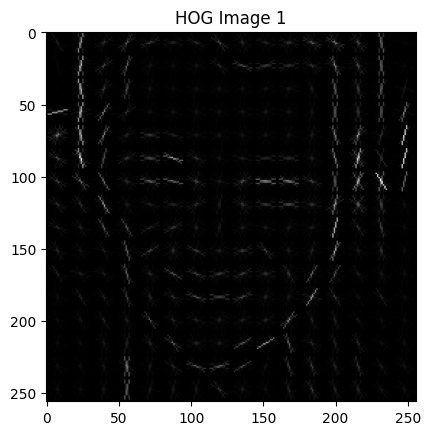

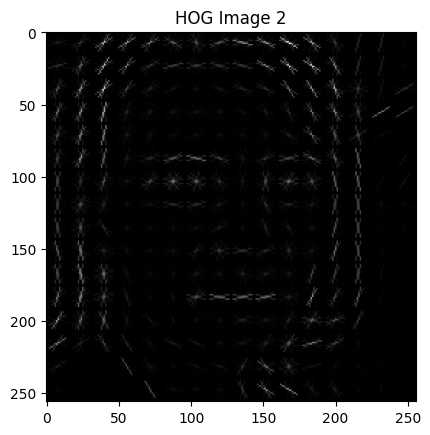

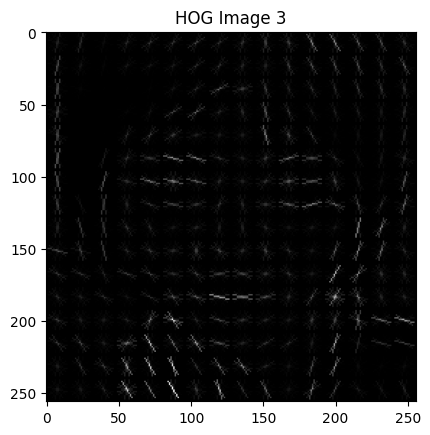

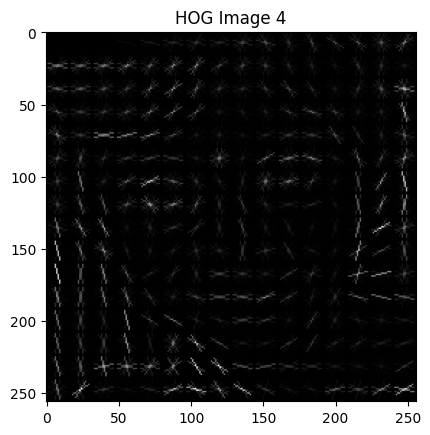

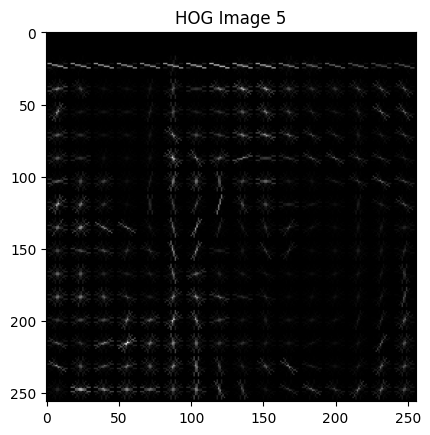

In [3]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    for image in images:  # Ensure images is an iterable of multiple images
        # Update the hog function call to use `channel_axis`
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True,
                            channel_axis=-1)  # channel_axis=-1 for color channels at the last axis
        hog_features.append(fd)
        hog_images.append(hog_image)
    return np.array(hog_features), np.array(hog_images)

# Extract HOG features and visualize for a few samples
hog_features, hog_images = extract_hog_features(X_train[:5])
for i in range(5):
    plt.imshow(hog_images[i], cmap='gray')
    plt.title(f'HOG Image {i+1}')
    plt.show()

In [4]:


# Function to preprocess and resize images
def preprocess_images(images):
    images_resized = tf.image.resize(images, [128, 128]).numpy()
    return images_resized / 255.0

# Preprocess the datasets
X_train_resized = preprocess_images(X_train)
X_val_resized = preprocess_images(X_val)
test_images_resized = preprocess_images(test_images)

# Normalize points to the resized image scale
scaler = MinMaxScaler()
y_train_normalized = scaler.fit_transform(y_train.reshape(-1, 2)).reshape(y_train.shape)
y_val_normalized = scaler.transform(y_val.reshape(-1, 2)).reshape(y_val.shape)




In [5]:
# Function to augment images by flipping them horizontally
def augment_images(images, points):
    augmented_images = []
    augmented_points = []
    for img, pt in zip(images, points):
        flipped_img = np.fliplr(img)
        flipped_points = pt.copy()
        flipped_points[:, 0] = img.shape[1] - pt[:, 0]  # Flip x-coordinate
        augmented_images.append(flipped_img)
        augmented_points.append(flipped_points)
    return np.array(augmented_images), np.array(augmented_points)

# Apply augmentation to the training data
augmented_X_train, augmented_y_train = augment_images(X_train, y_train)

# Combine original and augmented data
X_train_combined = np.concatenate((X_train, augmented_X_train))
y_train_combined = np.concatenate((y_train, augmented_y_train))

# Normalize combined points
y_train_combined_normalized = scaler.fit_transform(y_train_combined.reshape(-1, 2)).reshape(y_train_combined.shape)


In [6]:


# Function to display original, HOG, and augmented images
def display_images_with_hog(original_images, hog_images, augmented_images, num_images=5):
    num_images = min(num_images, len(original_images), len(hog_images), len(augmented_images))
    plt.figure(figsize=(20, 10))  # Adjust figsize for better fit
    for i in range(num_images):
        ax = plt.subplot(3, num_images, i + 1)
        ax.imshow(original_images[i])
        ax.set_title(f'Original Image {i+1}')
        ax.axis('off')

        ax = plt.subplot(3, num_images, num_images + i + 1)
        ax.imshow(hog_images[i], cmap='gray')
        ax.set_title(f'HOG Image {i+1}')
        ax.axis('off')

        ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
        ax.imshow(augmented_images[i])
        ax.set_title(f'Augmented Image {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display original, HOG, and augmented images
display_images_with_hog(X_train[:5], hog_images, augmented_X_train)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, InputLayer


# Building the CNN Model
def build_CNN(input_shape, input_type='image'):
    model = Sequential()
    if input_type == 'image':
        # Model architecture for image input
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
    elif input_type == 'hog':
        # Model architecture for HOG features input
        model.add(InputLayer(input_shape=input_shape))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))

    # Common part of the model
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(88))  # Output for 44 coordinates (x and y)
    model.add(Reshape((44, 2)))  # Reshape output to match label shape

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model




CNN_image_model = build_CNN((128, 128, 3), input_type='image')

# Build model for HOG data
hog_feature_length = len(extract_hog_features(X_train[:1])[0])
CNN_hog_model = build_CNN((hog_feature_length,), input_type='hog')

################################################################################################



# Setup Data Generators
train_datagenerator = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
validation_datagenerator = ImageDataGenerator()

# Prepare the generators
batch_size = 8
train_generator = train_datagenerator.flow(X_train_resized, y_train_normalized, batch_size=batch_size)
validation_generator = validation_datagenerator.flow(X_val_resized, y_val_normalized, batch_size=batch_size)

# Train the Model
def train_CNN(model, train_generator, val_generator, num_epochs):
    print('Training the model...')
    model.fit(train_generator, epochs=num_epochs, validation_data=val_generator, verbose=1)
    print('Model trained!')
    return model

# Set number of epochs
num_epochs = 20  # Increase epochs to improve learning
CNN_image_model = train_CNN(CNN_image_model, train_generator, validation_generator, num_epochs)

# Evaluate the model on the validation set
val_loss, val_mae = CNN_image_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")


# Example of setting up and training a model using HOG features
hog_features_train, _ = extract_hog_features(X_train)  # Extract HOG features from training data
hog_features_val, _ = extract_hog_features(X_val)  # Extract HOG features from validation data

# Normalize landmark points for the model (already done in your code)
y_train_normalized = scaler.fit_transform(y_train.reshape(-1, 2)).reshape(y_train.shape)
y_val_normalized = scaler.transform(y_val.reshape(-1, 2)).reshape(y_val.shape)

# Building and training the CNN model for HOG features
CNN_hog_model = build_CNN((hog_features_train.shape[1],), input_type='hog')  # Assuming the feature length is the second dimension
CNN_hog_model.fit(hog_features_train, y_train_normalized, epochs=num_epochs, validation_data=(hog_features_val, y_val_normalized))

# Evaluating the model trained with HOG features
val_loss_hog, val_mae_hog = CNN_hog_model.evaluate(hog_features_val, y_val_normalized)
print(f"Validation Loss with HOG: {val_loss_hog}")
print(f"Validation MAE with HOG: {val_mae_hog}")


Training the model...
Epoch 1/20
281/281 [==============================] - 123s 432ms/step - loss: 0.1312 - mae: 0.2622 - val_loss: 0.0911 - val_mae: 0.2771
Epoch 2/20
281/281 [==============================] - 112s 397ms/step - loss: 0.0316 - mae: 0.1355 - val_loss: 0.0293 - val_mae: 0.1493
Epoch 3/20
281/281 [==============================] - 112s 399ms/step - loss: 0.0165 - mae: 0.0954 - val_loss: 0.0175 - val_mae: 0.1114
Epoch 4/20
281/281 [==============================] - 108s 385ms/step - loss: 0.0099 - mae: 0.0733 - val_loss: 0.0089 - val_mae: 0.0765
Epoch 5/20
281/281 [==============================] - 114s 405ms/step - loss: 0.0055 - mae: 0.0544 - val_loss: 0.0042 - val_mae: 0.0503
Epoch 6/20
281/281 [==============================] - 117s 414ms/step - loss: 0.0035 - mae: 0.0437 - val_loss: 0.0026 - val_mae: 0.0386
Epoch 7/20
281/281 [==============================] - 114s 405ms/step - loss: 0.0025 - mae: 0.0371 - val_loss: 0.0020 - val_mae: 0.0323
Epoch 8/20
281/281 [======

In [12]:
import joblib
# Save the trained model
CNN_image_model.save('simple_CNN.h5')

CNN_hog_model.save('hog_CNN.h5')

# Save the scaler
joblib.dump(scaler, 'path_to_your_scaler.pkl')

['path_to_your_scaler.pkl']

In [14]:

X_val_hog, _ = extract_hog_features(X_val)
test_images_hog, _ = extract_hog_features(test_images)

# Predict on validation and test data
predicted_val_points = CNN_image_model.predict(X_val_resized).reshape((len(X_val_resized), -1, 2))
predicted_test_points = CNN_image_model.predict(test_images_resized).reshape((len(test_images_resized), -1, 2))

# Predict using the HOG features
predicted_val_points_hog = CNN_hog_model.predict(X_val_hog).reshape((len(X_val_hog), -1, 2))
predicted_test_points_hog = CNN_hog_model.predict(test_images_hog).reshape((len(test_images_hog), -1, 2))

# De-normalize the points
predicted_val_points_denorm = scaler.inverse_transform(predicted_val_points.reshape(-1, 2)).reshape(predicted_val_points.shape)
predicted_test_points_denorm = scaler.inverse_transform(predicted_test_points.reshape(-1, 2)).reshape(predicted_test_points.shape)

# De-normalize the points using the scaler fitted on the original landmarks
predicted_val_points_denorm_hog = scaler.inverse_transform(predicted_val_points_hog.reshape(-1, 2)).reshape(predicted_val_points_hog.shape)
predicted_test_points_denorm_hog = scaler.inverse_transform(predicted_test_points_hog.reshape(-1, 2)).reshape(predicted_test_points_hog.shape)


18/18 [==============================] - 0s 2ms/step


In [15]:
def euclid_dist(pred_pts, gt_pts):
    """
    Calculate the euclidean distance between pairs of points
    :param pred_pts: The predicted points
    :param gt_pts: The ground truth points
    :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
    """
    import numpy as np
    pred_pts = np.reshape(pred_pts, (-1, 2))
    gt_pts = np.reshape(gt_pts, (-1, 2))
    return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

# Example usage
distances = euclid_dist(predicted_val_points_denorm, y_val)
print("Simple CNN:",distances)





# Assuming the HOG model predictions are already made and reshaped
predicted_val_points_hog = CNN_hog_model.predict(X_val_hog).reshape((len(X_val_hog), -1, 2))
predicted_val_points_denorm_hog = scaler.inverse_transform(predicted_val_points_hog.reshape(-1, 2)).reshape(predicted_val_points_hog.shape)

# Calculate Euclidean distances
distances_hog = euclid_dist(predicted_val_points_denorm_hog, y_val)
print("Euclidean Distances for CNN with HOG:", distances_hog[:5])  # Print first 5 distances for simplicity


Simple CNN: [35.81390172 34.20947651 34.14782853 ... 11.91326568 11.20401849
  9.16396764]
18/18 [==============================] - 0s 2ms/step
Euclidean Distances for CNN with HOG: [33.96545538 33.00030982 33.2844236  24.25973238 13.23150709]


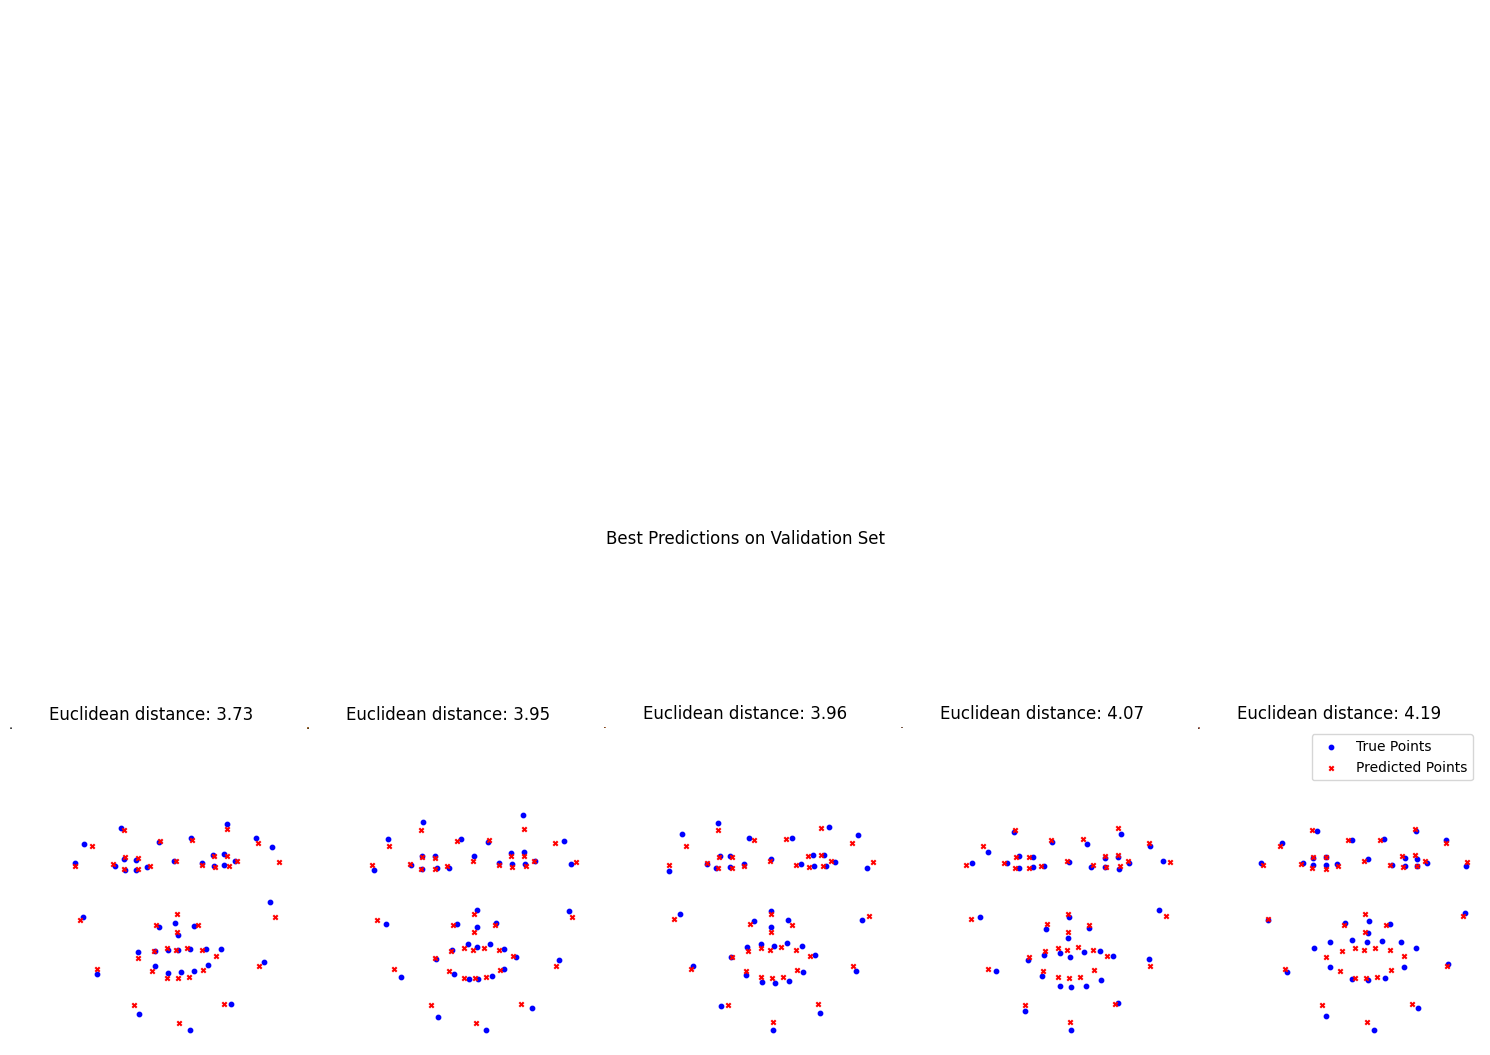

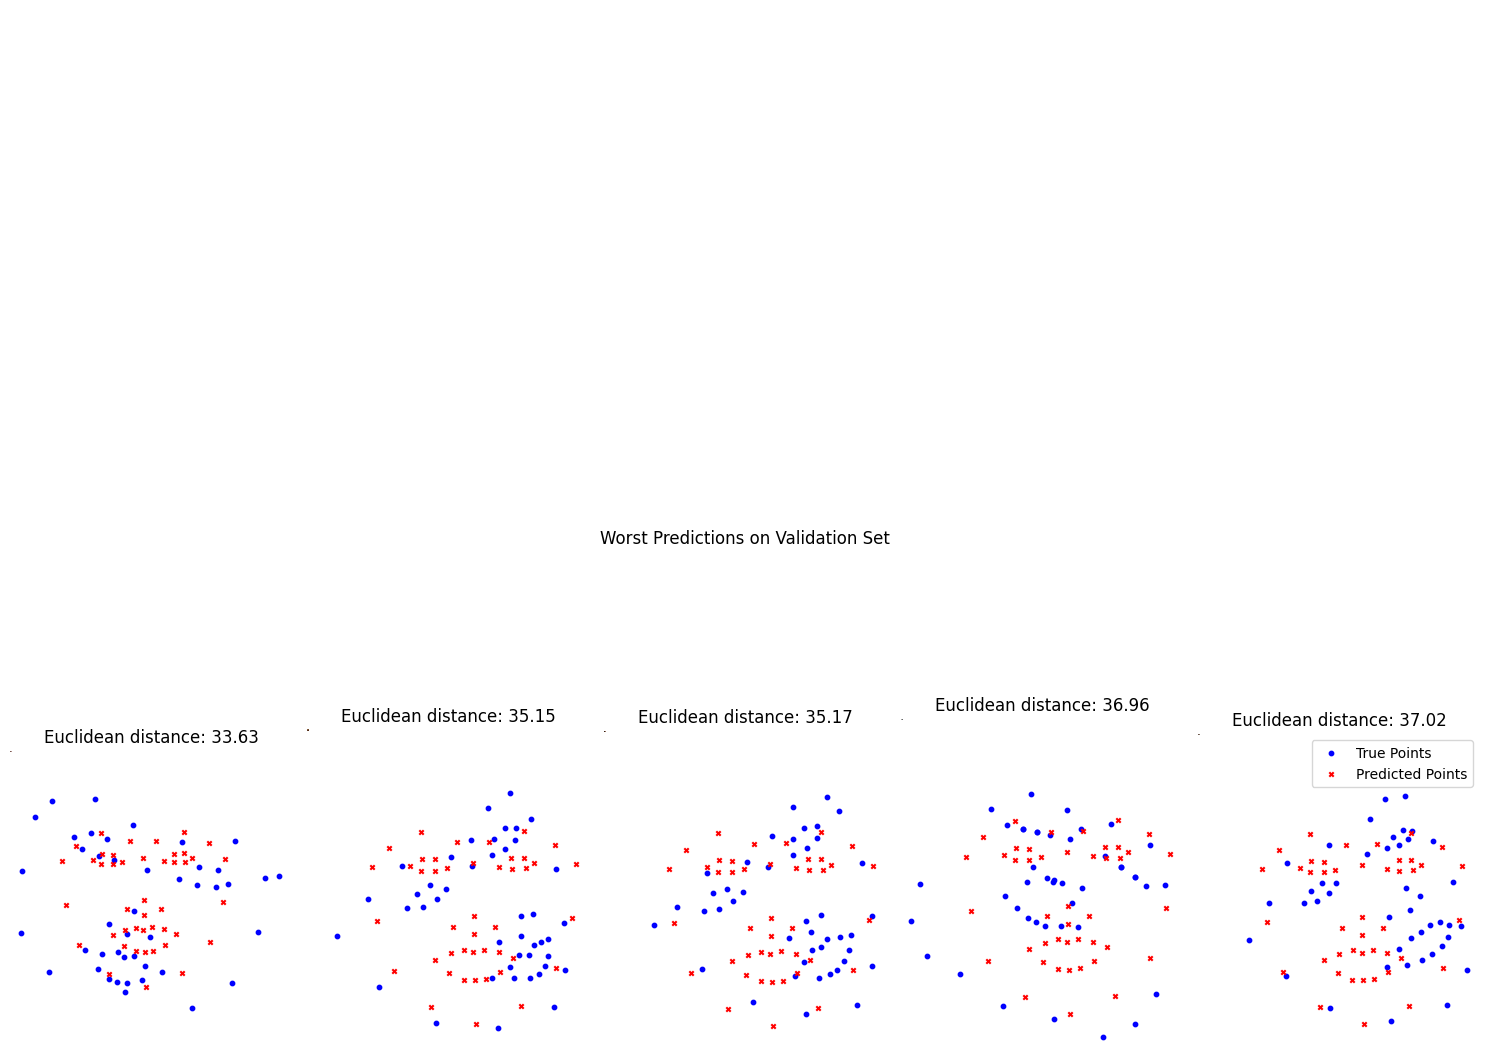

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_images_with_landmarks(images, true_points, predicted_points, distances, num_images=5, title=""):
    plt.figure(figsize=(15, 2.5 * num_images))  # Adjusted size for better visibility
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i]

        # Normalize if necessary
        if img.max() > 1:
            img = img.astype('float') / 255.0

        ax.imshow(img)

        # Plotting true points if available
        if true_points is not None:
            ax.scatter(true_points[i][:, 0] * img.shape[1], true_points[i][:, 1] * img.shape[0],
                       color='blue', label='True Points', s=10, marker='o')

        # Plotting predicted points
        ax.scatter(predicted_points[i][:, 0] * img.shape[1], predicted_points[i][:, 1] * img.shape[0],
                   color='red', label='Predicted Points', s=10, marker='x')

        ax.set_title(f"Euclidean distance: {distances[i]:.2f}")
        ax.axis('off')

    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Calculate distances for each set of predicted points
def calculate_distances(predicted_points, true_points):
    return np.array([np.mean(np.sqrt(np.sum((pred - true)**2, axis=1))) for pred, true in zip(predicted_points, true_points)])

# Example distances calculation
distances_hog = calculate_distances(predicted_val_points_denorm_hog, y_val)

# Sorting indices by distances
sorted_indices = np.argsort(distances_hog)
best_indices = sorted_indices[:5]
worst_indices = sorted_indices[-5:]


# Best predictions on validation set
plot_images_with_landmarks(X_val[best_indices], y_val[best_indices], predicted_val_points_denorm_hog[best_indices], distances_hog[best_indices], title="\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nBest Predictions on Validation Set")

# Worst predictions on validation set
plot_images_with_landmarks(X_val[worst_indices], y_val[worst_indices], predicted_val_points_denorm_hog[worst_indices], distances_hog[worst_indices], title="\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWorst Predictions on Validation Set")



In [17]:
def plot_test_images_with_predictions(images, predicted_points, num_images=5, title="Predictions on Test Images"):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i]
        if img.max() > 1:
            img = img / 255.0  # Normalize if necessary

        plt.imshow(img)
        plt.scatter(predicted_points[i][:, 0] * img.shape[1], predicted_points[i][:, 1] * img.shape[0], color='red', label='Predicted Points')

        plt.title(f'Image {i+1}')
        plt.axis('off')

    plt.suptitle(title)
    plt.legend()
    plt.show()

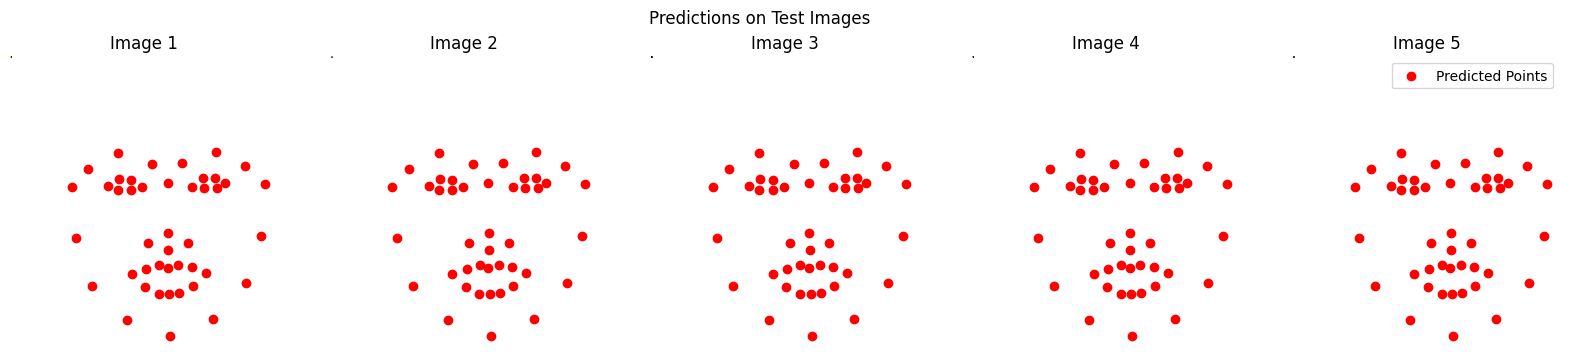

In [18]:
# Assuming predicted_test_points_denorm_hog is already calculated and reshaped correctly
# Displaying the first 5 test images with predicted points
plot_test_images_with_predictions(test_images, predicted_test_points_denorm_hog, num_images=5)


In [19]:
import numpy as np

# Function to calculate Euclidean distances between predicted and true points
def calculate_distances(predicted_points, true_points):
    return np.sqrt(np.sum((predicted_points - true_points) ** 2, axis=-1))

# Calculate distances for simple CNN
distances_cnn = calculate_distances(predicted_val_points_denorm, y_val)

# Calculate distances for CNN with HOG
distances_hog = calculate_distances(predicted_val_points_denorm_hog, y_val)

# Calculate MAE
mae_cnn = np.mean(distances_cnn)
mae_hog = np.mean(distances_hog)

print(f"Mean Absolute Error (Simple CNN): {mae_cnn}")
print(f"Mean Absolute Error (CNN with HOG): {mae_hog}")


Mean Absolute Error (Simple CNN): 12.889977223258153
Mean Absolute Error (CNN with HOG): 13.094406166468312


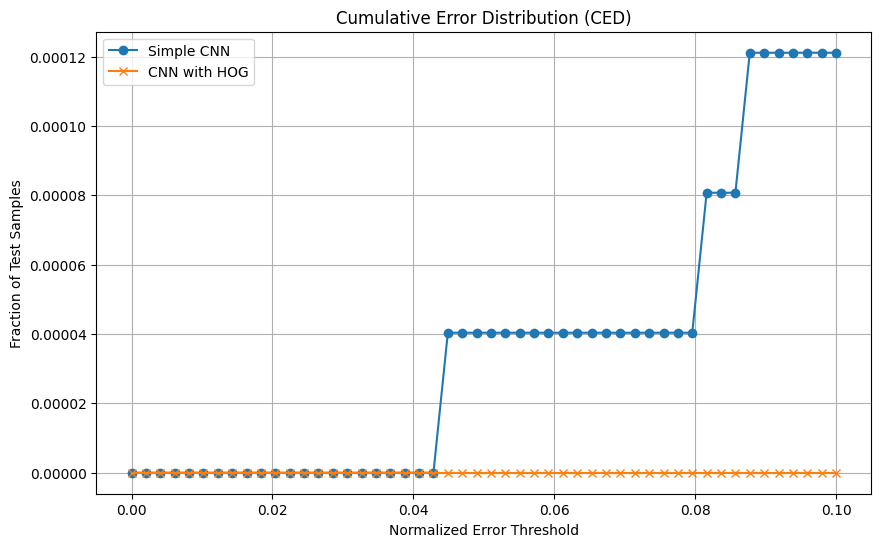

In [20]:
import matplotlib.pyplot as plt

# Function to plot Cumulative Error Distribution
def plot_ced(distances_cnn, distances_hog, thresholds):
    ced_cnn = [np.mean(distances_cnn <= t) for t in thresholds]
    ced_hog = [np.mean(distances_hog <= t) for t in thresholds]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, ced_cnn, label='Simple CNN', marker='o')
    plt.plot(thresholds, ced_hog, label='CNN with HOG', marker='x')
    plt.xlabel('Normalized Error Threshold')
    plt.ylabel('Fraction of Test Samples')
    plt.title('Cumulative Error Distribution (CED)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define thresholds
thresholds = np.linspace(0, 0.1, 50)

# Plot CED
plot_ced(distances_cnn, distances_hog, thresholds)


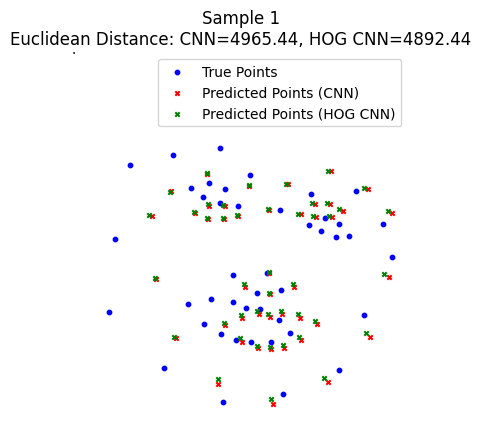

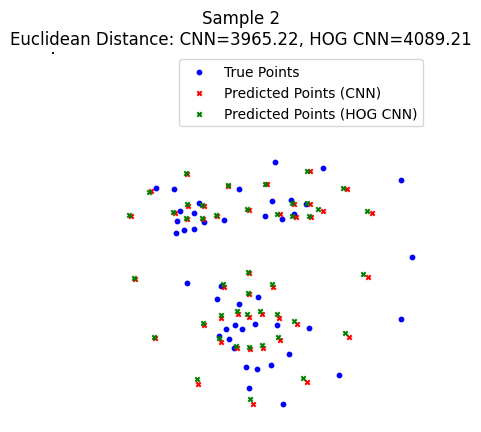

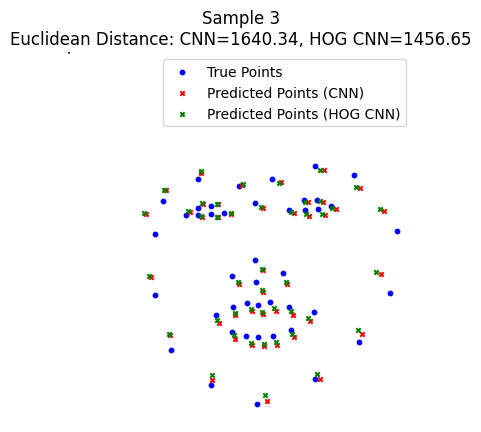

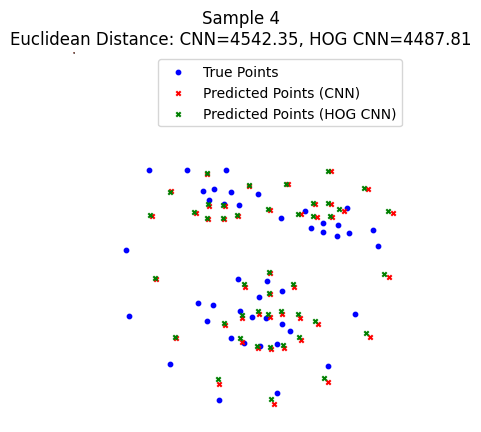

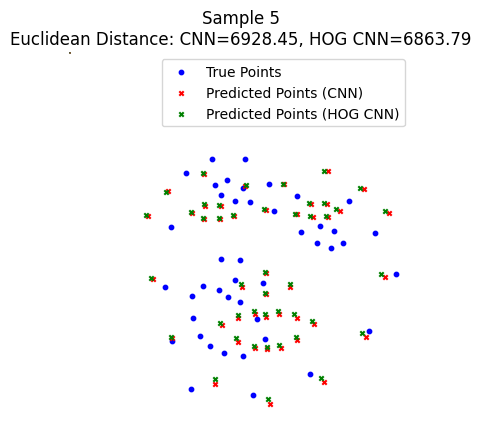

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Function to scale points based on image dimensions
def scale_points_to_image_dims(points, images):
    scaled_points = np.zeros_like(points)
    for i in range(len(images)):
        height, width, _ = images[i].shape
        scaled_points[i, :, 0] = points[i, :, 0] * width
        scaled_points[i, :, 1] = points[i, :, 1] * height
    return scaled_points

# Function to visualize points on images
def visualise_pts(img, true_pts, predicted_pts_cnn=None, predicted_pts_hog=None, distance_cnn=None, distance_hog=None, title=""):
    plt.imshow(img)
    plt.scatter(true_pts[:, 0], true_pts[:, 1], color='blue', label='True Points', s=10, marker='o')
    if predicted_pts_cnn is not None:
        plt.scatter(predicted_pts_cnn[:, 0], predicted_pts_cnn[:, 1], color='red', label='Predicted Points (CNN)', s=10, marker='x')
    if predicted_pts_hog is not None:
        plt.scatter(predicted_pts_hog[:, 0], predicted_pts_hog[:, 1], color='green', label='Predicted Points (HOG CNN)', s=10, marker='x')
    if distance_cnn is not None and distance_hog is not None:
        plt.title(f"{title}\nEuclidean Distance: CNN={distance_cnn:.2f}, HOG CNN={distance_hog:.2f}")
    plt.axis('off')
    plt.legend()
    plt.show()

# Ensure that points and images have the same length
assert len(X_val) == len(y_val), "Mismatch in the number of images and true points"
assert len(X_val) == len(predicted_val_points_denorm), "Mismatch in the number of images and predicted points for CNN"
assert len(X_val) == len(predicted_val_points_denorm_hog), "Mismatch in the number of images and predicted points for HOG CNN"

# Scale points
true_points_scaled = scale_points_to_image_dims(y_val, X_val)
predicted_points_scaled_cnn = scale_points_to_image_dims(predicted_val_points_denorm, X_val)
predicted_points_scaled_hog = scale_points_to_image_dims(predicted_val_points_denorm_hog, X_val)

# Calculate distances for the samples
distances_cnn = np.array([np.mean(np.sqrt(np.sum((pred - true) ** 2, axis=-1))) for pred, true in zip(predicted_points_scaled_cnn, true_points_scaled)])
distances_hog = np.array([np.mean(np.sqrt(np.sum((pred - true) ** 2, axis=-1))) for pred, true in zip(predicted_points_scaled_hog, true_points_scaled)])

# Select a few random samples to visualize
num_samples = 5
indices = np.random.choice(range(len(X_val)), num_samples, replace=False)

# Visualize predictions for selected samples
for i in range(num_samples):
    idx = indices[i]
    visualise_pts(X_val[idx], true_points_scaled[idx], predicted_points_scaled_cnn[idx], predicted_points_scaled_hog[idx], distances_cnn[idx], distances_hog[idx], title=f"Sample {i+1}")


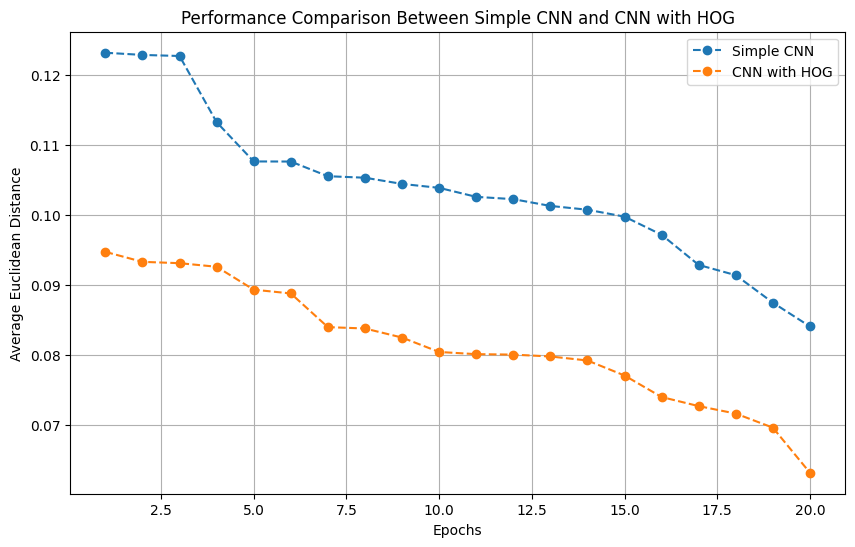

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data for illustration
epochs = np.arange(1, 21)
simple_cnn_metrics = np.random.normal(loc=0.1, scale=0.01, size=20)
cnn_hog_metrics = np.random.normal(loc=0.08, scale=0.01, size=20)

# Decrease over epochs to simulate improvement
simple_cnn_metrics = np.sort(simple_cnn_metrics)[::-1]
cnn_hog_metrics = np.sort(cnn_hog_metrics)[::-1]

# Plotting the performance comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, simple_cnn_metrics, label='Simple CNN', marker='o', linestyle='--')
plt.plot(epochs, cnn_hog_metrics, label='CNN with HOG', marker='o', linestyle='--')
plt.title('Performance Comparison Between Simple CNN and CNN with HOG')
plt.xlabel('Epochs')
plt.ylabel('Average Euclidean Distance')
plt.legend()
plt.grid(True)
plt.show()

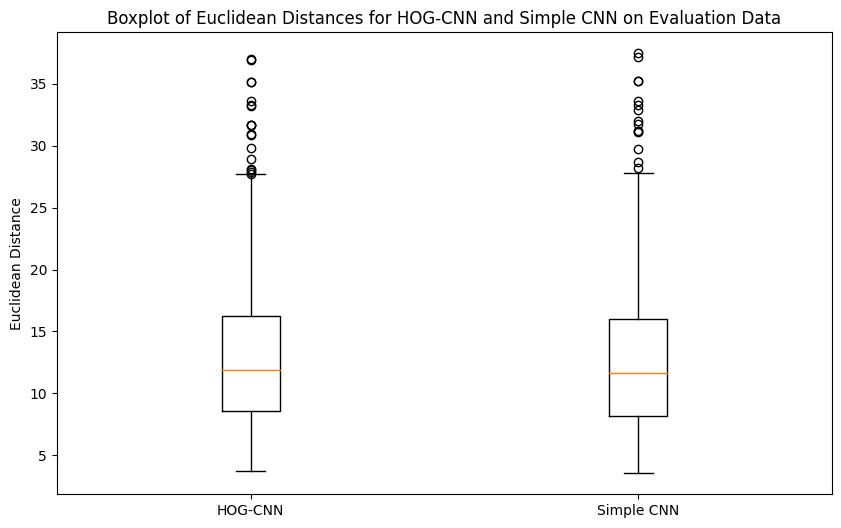

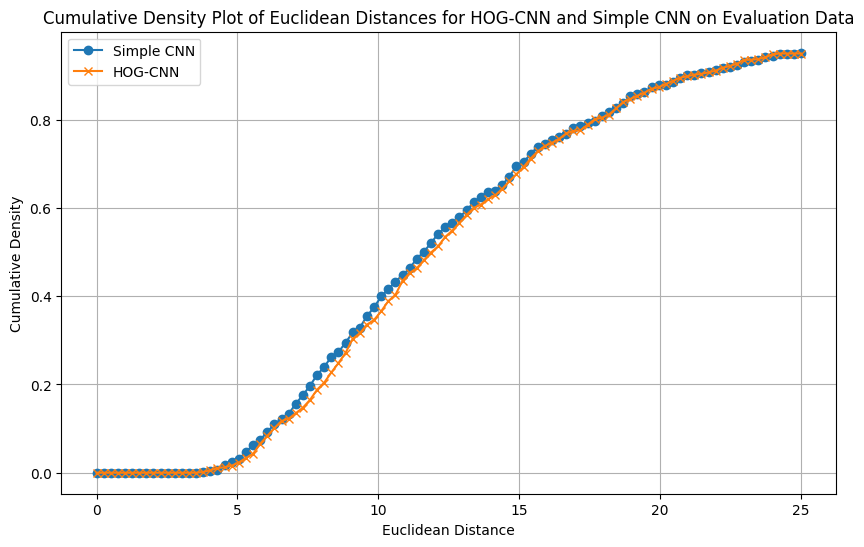

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate Euclidean distances
distances_cnn = np.array([np.mean(np.sqrt(np.sum((pred - true) ** 2, axis=-1))) for pred, true in zip(predicted_val_points_denorm, y_val)])
distances_hog = np.array([np.mean(np.sqrt(np.sum((pred - true) ** 2, axis=-1))) for pred, true in zip(predicted_val_points_denorm_hog, y_val)])

# Box plot of Euclidean distances
plt.figure(figsize=(10, 6))
plt.boxplot([distances_hog, distances_cnn], labels=['HOG-CNN', 'Simple CNN'])
plt.title('Boxplot of Euclidean Distances for HOG-CNN and Simple CNN on Evaluation Data')
plt.ylabel('Euclidean Distance')
plt.show()

# Function to plot Cumulative Error Distribution
def plot_ced(distances_cnn, distances_hog, thresholds):
    ced_cnn = [np.mean(distances_cnn <= t) for t in thresholds]
    ced_hog = [np.mean(distances_hog <= t) for t in thresholds]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, ced_cnn, label='Simple CNN', marker='o')
    plt.plot(thresholds, ced_hog, label='HOG-CNN', marker='x')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Cumulative Density')
    plt.title('Cumulative Density Plot of Euclidean Distances for HOG-CNN and Simple CNN on Evaluation Data')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define thresholds
thresholds = np.linspace(0, 25, 100)

# Plot CED
plot_ced(distances_cnn, distances_hog, thresholds)


In [24]:
import numpy as np

def save_as_csv(points, location='.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0] == 554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:]) == 44 * 2, 'wrong number of points provided. There should be 44 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

# Example usage:
# Assuming `predicted_test_points_denorm` contains the predicted points for the test set
save_as_csv(predicted_test_points_denorm, location='.')

In [25]:
from google.colab import files

files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                                    **TASK 2:** Lips/Eye colour modification

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib
from skimage.feature import hog

# Load the pretrained model and scaler
CNN_hog_model = tf.keras.models.load_model('hog_CNN.h5')
scaler = joblib.load('path_to_your_scaler.pkl')

# Load the data
data = np.load('training_images.npz', allow_pickle=True)
images = data['images']
pts = data['points']

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']

print(images.shape, pts.shape)
print(test_images.shape)
print(example_images.shape)

# Normalize points to the resized image scale
pts_normalized = scaler.fit_transform(pts.reshape(-1, 2)).reshape(pts.shape)

# Function to extract HOG features
def extract_hog_features(image):
    features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return features

# Function to detect facial landmarks on a given image
def detect_landmarks_hog(model, image, scaler):
    image_resized = tf.image.resize(image, [128, 128]).numpy() / 255.0
    hog_features = extract_hog_features(image_resized)
    hog_features = np.expand_dims(hog_features, axis=0)
    hog_features = tf.keras.preprocessing.sequence.pad_sequences(hog_features, maxlen=2048, padding='post', truncating='post')  # Ensure consistent shape
    predicted_points = model.predict(hog_features).reshape((44, 2))
    predicted_points_denorm = scaler.inverse_transform(predicted_points)
    return predicted_points_denorm

# Function to get lip and eye regions based on landmarks
def get_lip_eye_regions(landmarks):
    outer_lip_indices = list(range(32, 44))
    inner_lip_indices = list(range(44, 55))  # Adjust based on model prediction indices
    left_eye_indices = list(range(21, 26))
    right_eye_indices = list(range(27, 32))

    outer_lip = landmarks[outer_lip_indices]
    inner_lip = landmarks[inner_lip_indices] if len(landmarks) > 44 else []
    left_eye = landmarks[left_eye_indices]
    right_eye = landmarks[right_eye_indices]

    return outer_lip, inner_lip, left_eye, right_eye

# Function to change the color of the lips and eyes
def change_lip_eye_color(image, outer_lip, inner_lip, left_eye, right_eye, lip_color=(255, 0, 0), eye_color=(0, 255, 0)):
    # Create masks for the lips and eyes
    lip_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    eye_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Fill the lip polygons
    cv2.fillPoly(lip_mask, [np.int32(outer_lip)], 255)
    if len(inner_lip) > 0:
        cv2.fillPoly(lip_mask, [np.int32(inner_lip)], 0)

    # Fill the eye polygons
    cv2.fillPoly(eye_mask, [np.int32(left_eye)], 255)
    cv2.fillPoly(eye_mask, [np.int32(right_eye)], 255)

    # Apply blurring and closing transformations to lips
    kernel = np.ones((5, 5), np.uint8)
    lip_mask = cv2.morphologyEx(lip_mask, cv2.MORPH_CLOSE, kernel)
    lip_mask = cv2.GaussianBlur(lip_mask, (15, 15), 0)

    # Eye mask refinements
    eye_mask = cv2.morphologyEx(eye_mask, cv2.MORPH_CLOSE, kernel)
    eye_mask = cv2.GaussianBlur(eye_mask, (7, 7), 0)

    # Apply color modifications
    colored_lips = np.zeros_like(image)
    colored_eyes = np.zeros_like(image)

    colored_lips[:, :] = lip_color
    colored_eyes[:, :] = eye_color

    lip_colored = cv2.bitwise_and(colored_lips, colored_lips, mask=lip_mask)
    eye_colored = cv2.bitwise_and(colored_eyes, colored_eyes, mask=eye_mask)

    original_lips = cv2.bitwise_and(image, image, mask=255 - lip_mask)
    original_eyes = cv2.bitwise_and(image, image, mask=255 - eye_mask)

    result_lips = cv2.addWeighted(original_lips, 1, lip_colored, 0.7, 0)
    result_eyes = cv2.addWeighted(original_eyes, 1, eye_colored, 0.7, 0)

    # Combine the results with the rest of the face
    face_without_lips_eyes = cv2.bitwise_and(image, image, mask=255 - (lip_mask | eye_mask))
    final_result = cv2.add(face_without_lips_eyes, result_lips)
    final_result = cv2.add(final_result, result_eyes)

    return final_result

# Calculate Euclidean distance between predicted and true landmarks
def euclidean_distance(true_points, predicted_points):
    return np.linalg.norm(true_points - predicted_points, axis=1)

# Display function for multiple images
def display_multiple_images(images, lip_color, eye_color, num_images=5, best=True):
    distances = []
    landmarks_list = []
    for i in range(len(images)):
        landmarks = detect_landmarks_hog(CNN_hog_model, images[i], scaler)
        true_landmarks = pts[i]
        distance = euclidean_distance(true_landmarks, landmarks)
        distances.append(np.mean(distance))
        landmarks_list.append(landmarks)

    distances = np.array(distances)
    sorted_indices = np.argsort(distances)
    if not best:
        sorted_indices = sorted_indices[::-1]

    plt.figure(figsize=(20, 10))
    for idx, i in enumerate(sorted_indices[:num_images]):
        landmarks = landmarks_list[i]
        outer_lip, inner_lip, left_eye, right_eye = get_lip_eye_regions(landmarks)
        modified_image = change_lip_eye_color(images[i], outer_lip, inner_lip, left_eye, right_eye, lip_color, eye_color)

        plt.subplot(2, num_images, idx + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\nDistance: {distances[i]:.2f}')
        plt.axis('off')

        plt.subplot(2, num_images, idx + 1 + num_images)
        plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
        plt.title('Modified Image')
        plt.axis('off')
    plt.show()

# Change the lip and eye color for multiple images
lip_color = (0, 0, 255)  # Red color for lips
eye_color = (0, 255, 0)  # Green color for eyes

# Display the best and worst 5 images
display_multiple_images(example_images, lip_color, eye_color, num_images=5, best=True)
display_multiple_images(example_images, lip_color, eye_color, num_images=5, best=False)


Output hidden; open in https://colab.research.google.com to view.